# Unsupervised feature selection with global DIFFI

In this notebook are reproduced the experimental results on unsupervised feature selection with global DIFFI described in our paper [Interpretable Anomaly Detection with DIFFI: Depth-based Feature Importance for the Isolation Forest](https://arxiv.org/pdf/2007.11117.pdf).

The present code represents the very first release of the DIFFI algorithm: the code in this version is not yet optimized.

In [6]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
%matplotlib inline
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
import interpretability_module as interp
from utils import *

### Load data

In [2]:
df=pd.read_excel(r'DiabetesDiagnosis.xls')


Loaded lympho dataset: 148 samples, 18 features.
4.05 percent outliers.


### Get the feature ranking based on the global DIFFI method
We use $N_{fs}=5$.

In [15]:
df

,Pregnancies,PG Concentration,Diastolic BP,Tri Fold Thick,Serum Ins,BMI,DP Function,Age,Diagnosis
0,6,148,72,35,0,33.6,0.627,50,0
1,1,85,66,29,0,26.6,0.351,31,1
2,8,183,64,0,0,23.3,0.672,32,0
3,1,89,66,23,94,28.1,0.167,21,1
4,0,137,40,35,168,43.1,2.288,33,0
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,1
764,2,122,70,27,0,36.8,0.340,27,1
765,5,121,72,23,112,26.2,0.245,30,1
766,1,126,60,0,0,30.1,0.349,47,0


In [19]:
X,y=df.drop('Diagnosis',axis=1).to_numpy(),df['Diagnosis'].to_numpy()

In [20]:
sorted_idx, avg_f1_ranking = diffi_ranks(X, y, n_trees=100, max_samples=256, n_iter=5)

Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` i

### Train the Isolation Forest
We train the Isolation Forest by exploiting a variable number $k$ of features, ranging from $1$ to $p$ (where $p$ is the maximum number of available features, which depends on the selected dataset). For each value of $k$, we perform $n_{iter}=30$ runs of the algorithm and compute the median F1 score. For the Isolation Forest we use hyperparameters values tuned on the original dataset (just to make sure we are considering a reasonable model).

In [21]:
n_iter = 30

n_feats_max = X.shape[1]
y[y==1] = -1
y[y==0] = 1
hyper = fs_datasets_hyperparams(dataset_id)
out_dict = {}
for n_feats in range(1, n_feats_max+1):
    X_sel_feats = X[:, sorted_idx[:n_feats]]
    f1_all = []
    for j in range(n_iter):
        m = IsolationForest(**hyper, random_state=j)
        m.fit(X_sel_feats)
        y_pred = m.predict(X_sel_feats)
        f1_all.append(f1_score(y, y_pred))
    out_dict[n_feats] = np.median(f1_all)

### Plot average F1 score as a function of the number of features exploited

Text(0.5, 1.0, 'lympho dataset')

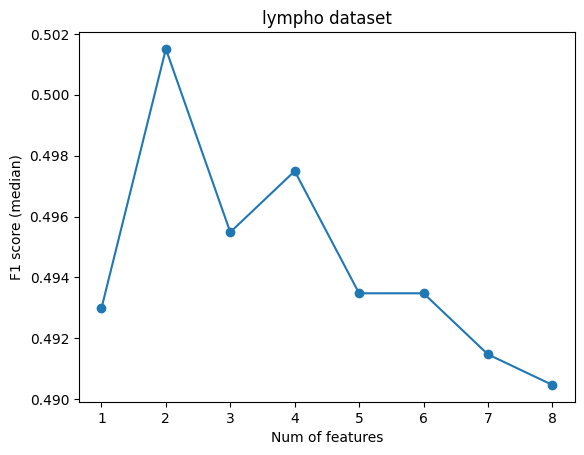

In [22]:
plt.xticks(list(out_dict.keys()))
plt.plot(list(out_dict.keys()), list(out_dict.values()), '-o')
plt.xlabel('Num of features')
plt.ylabel('F1 score (median)')
plt.title('{} dataset'.format(dataset_id))